In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [14]:
# right-hand side of ODE from "Axion dark matter, solitons and the cusp–core problem" Appendix A
def f(r, X):
    f1 = X[1]
    f2 = -2*X[1]/r + 2*X[2]*X[0]
    f3 = X[3]
    f4 = -2*X[3]/r + np.power(X[0],2)
    return np.array([f1, f2, f3, f4])

# interval of solution and number of steps
ri, rf = 0, 15
steps = 10000
dr = (rf - ri)/steps
rinterv = np.linspace(ri, rf, steps, endpoint=True)

# single step of RK4
def rk4step(r, X):
    k1 = dr*f(r, X)
    k2 = dr*f(r + dr/2, X + k1/2)
    k3 = dr*f(r + dr/2, X + k2/2)
    k4 = dr*f(r + dr, X + k3)
    return X + (k1 + 2*k2 + 2*k3 + k4)/6

def rk4(Xbc):
    # initialize the arrays
    Xs = np.zeros((4, steps))

    # boundary conditions at r = ri
    Xs[..., 0] = Xbc

    # perform RK4
    bpoint = steps
    for step in np.arange(1, steps):
        rnow = rinterv[step]
        Xs[..., step] = rk4step(rnow, Xs[..., step - 1])
    
        # the breakpoint 'bpoint' occurs when the solution stops converging to zero at r -> infty
        if np.log(np.abs(Xs[..., step][0])) > np.log(np.abs(Xs[..., step - 1][0])):
            bpoint = step
            return Xs, bpoint

    return Xs, bpoint

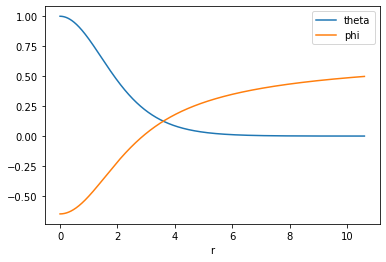

In [15]:
# Reproducing solution from Doddy's papper
phi0dd = -1.3415238997 + 0.692
Xbcdd = np.array([1, 0, phi0dd, 0]) # theta0 is taken to be 1 using the scaling relations

Xs = rk4(Xbcdd)[0]
bpoint = rk4(Xbcdd)[1]
plt.plot(rinterv[:bpoint], Xs[0].T[:bpoint], label = "theta")
plt.plot(rinterv[:bpoint], Xs[2].T[:bpoint], label = "phi")
plt.xlabel("r")
plt.legend();

In [19]:
# Step of Monte Carlo for shooting method
def mc_step(phi0, bpointold):
    Xbc_step = np.array([1, 0, phi0, 0])
    Xs_step, bpoint = rk4(Xbc_step)

    # If the breakpoint happens for higher values of r, keep the new solution (ground state should have breakpoint at infty)
    if bpoint > bpointold:
        return True, bpoint
    elif bpoint <= bpointold:
        return False, bpointold

# Full Monte Carlo
def find_sol():
    bpoint = 0
    phi0 = np.random.uniform(-1,0)
    direc = 1

    nsteps = 10000
    # count avoids the code 'getting stuck' for large periods of time
    count = 1
    for i in np.arange(nsteps):
        phi0old = phi0
        phi0 += direc*np.abs(np.random.normal(0,1e-2))

        mcs = mc_step(phi0, bpoint)
        if mcs[0]:
            bpoint = mcs[1]
        else:
            phi0 = phi0old
            direc *= -1
            count += 1
            
        if count > 100:
            return phi0, bpoint

    return phi0, bpoint

In [20]:
# run find_sol many times, the 'best solution' will have the largest value of bpoint
bpoints, phis = [], []
for i in np.arange(1):
    phi, bpoint = find_sol()
    phis.append(phi)
    bpoints.append(bpoint)

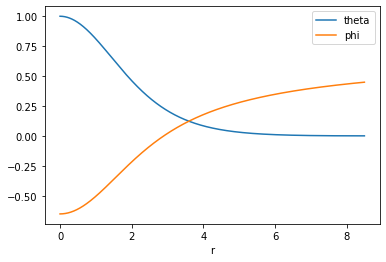

In [21]:
# Plotting best solution
phi0_plt = phis[bpoints.index(max(bpoints))]
Xbc_plt = np.array([1, 0, phi0_plt, 0])
Xs = rk4(Xbc_plt)[0]
bpoint = rk4(Xbc_plt)[1]

plt.plot(rinterv[:bpoint], Xs[0].T[:bpoint], label = "theta")
plt.plot(rinterv[:bpoint], Xs[2].T[:bpoint], label = "phi")
plt.xlabel("r")
plt.legend();

In [22]:
# Find gamma from asymptotic behavior of phi
phi0_plt = phis[bpoints.index(max(bpoints))]
Xbc_plt = np.array([1, 0, phi0_plt, 0])

Xs = rk4(Xbc_plt)[0]
bpoint = rk4(Xbc_plt)[1]
r_asymp, phi_asymp = rinterv[bpoint - 100:bpoint], Xs[2].T[bpoint - 100:bpoint]

def fit_asymp(r, C, gamma):
    return C/r - gamma

popt, pcov = curve_fit(fit_asymp, r_asymp, phi_asymp)
gamma = popt[1]
gamma

-0.6925757012797158

In [23]:
# Find phi0 from phi at r = 0
phi0 = Xs[2].T[0] + gamma
phi0

-1.3420794597800723